In [0]:
%reload_ext autoreload 
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = Path('/content/disaster_tweets')
path.mkdir(exist_ok=True)
import zipfile
with zipfile.ZipFile('/content/nlp-getting-started.zip') as f:
  f.extractall(path)

In [0]:
df = pd.read_csv(path/'train.csv',low_memory = False)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
df[['text']].head()

,text
0,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...


In [0]:
df_test = pd.read_csv(path/'test.csv')

In [0]:
df_test.shape

(3263, 4)

In [0]:
x_full = pd.concat([df[['text']],df_test[['text']]])

In [0]:
x_full.shape

(10876, 1)

In [0]:
data_lm = TextList.from_df(x_full,cols='text').split_by_rand_pct(0.1).label_for_lm().databunch(bs=48)

In [0]:
data_lm.show_batch(3)

idx,text
0,"wildfires xxunk into a school xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk , xxmaj colorado xxmaj springs areas xxbos i 'm on top of the hill and i can see a fire"
1,: xxmaj stop the xxmaj annihilation of the xxmaj salt xxmaj river xxmaj wild xxmaj horse ... https : / / t.co / xxunk via @change xxbos xxunk can you please sign and share this petition to save wild horses in xxmaj arizona . http : / / t.co / xxunk xxrep 4 ? xxbos xxup u.s xxmaj national xxmaj park xxmaj services xxmaj tonto xxmaj national xxmaj forest :
2,. xxbos xxunk not everyone can see xxunk is xxmaj xxunk that is xxmaj all she can ever xxunk xxunk an attack dog 4 a hate group xxup gop xxbos xxmaj heart disease prevention : xxmaj what about xxunk smoke ? http : / / t.co / xxunk xxbos a xxmaj xxunk - area org tells me it was hit by a xxunk attack : http : / / t.co


In [0]:
data_lm.save('data_lm')

In [0]:
cp -rf /content/data_lm /content/drive/My\ Drive/Data/Disaster

In [0]:
learn_lm = language_model_learner(data_lm,AWD_LSTM,drop_mult=0.4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


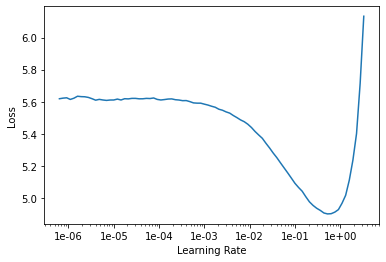

In [0]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [0]:
learn_lm.fit_one_cycle(10,3e-02,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.312391,3.468959,0.408003,00:08
1,3.451588,3.069576,0.459458,00:08
2,3.079111,3.061832,0.464649,00:08
3,2.811147,3.058180,0.472255,00:08
4,2.616935,3.068683,0.476124,00:08
5,2.424164,3.060970,0.483499,00:08
6,2.245210,3.066327,0.486806,00:08
7,2.082990,3.073632,0.488492,00:08
8,1.956841,3.075794,0.488922,00:08
9,1.893051,3.078987,0.489583,00:08


In [0]:
learn_lm.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


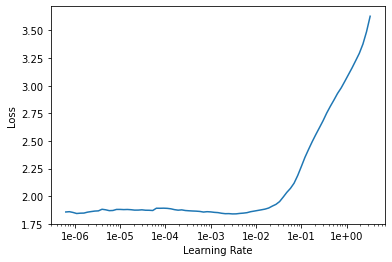

In [0]:
learn_lm.unfreeze()
learn_lm.lr_find()
learn_lm.recorder.plot()

In [0]:
learn_lm.fit_one_cycle(6,slice(1e-05,2e-03))

epoch,train_loss,valid_loss,accuracy,time
0,1.861928,3.087344,0.490476,00:08
1,1.835367,3.095317,0.492460,00:08
2,1.801036,3.101784,0.493122,00:08
3,1.760135,3.115353,0.492593,00:08
4,1.727738,3.117856,0.491336,00:08
5,1.714062,3.117904,0.492493,00:08


In [0]:
learn_lm.save('stage-2')

In [0]:
learn_lm.save_encoder('enc')

In [0]:
data_cls = TextList.from_df(df,cols='text',vocab=data_lm.vocab).split_by_rand_pct(0.1).label_from_df('target').add_test(df_test['text']).databunch(bs=48)

In [0]:
data_cls.show_batch(3)

text,target
xxbos _ \n xxrep 5 ? xxup retweet \n xxrep 7 ? \n xxrep 5 ? xxup follow xxup all xxup who xxup rt \n xxrep 7 ? \n xxrep 5 ? xxup xxunk \n xxrep 7 ? \n xxrep 5 ? xxup gain xxup with \n xxrep 7 ? \n xxrep 5 ? xxup follow ? xxunk # xxup xxunk,0
xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n \n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0
xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0


In [0]:
learn_cls = text_classifier_learner(data_cls,AWD_LSTM,drop_mult=0.4)

In [0]:
learn_cls.load_encoder('enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6852 items)
x: TextList
xxbos xxmaj our xxmaj xxunk are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj forgive us all,xxbos xxmaj forest fire near xxmaj la xxmaj xxunk xxmaj xxunk . xxmaj canada,xxbos xxmaj all residents asked to ' shelter in place ' are being xxunk by officers . xxmaj no other evacuation or shelter in place orders are expected,xxbos xxunk people receive # wildfires evacuation orders in xxmaj california,xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school
y: CategoryList
1,1,1,1,1
Path: .;

Valid: LabelList (761 items)
x: TextList
xxbos xxmaj he came to a land which was engulfed in tribal war and turned it into a land of peace i.e. xxmaj madinah . # prophetmuhammad # islam,xxbos xxup xxunk responds : fedex no longer to transport bioterror germs in wake of anthrax lab mishaps http : / / t.co / xxunk,xxbos reap the whirlwind,xxbos https : 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


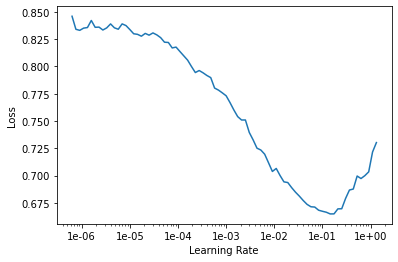

In [0]:
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(4,2e-02,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.541590,0.523413,0.752957,00:06
1,0.528866,0.493093,0.759527,00:06
2,0.504813,0.484371,0.766097,00:06
3,0.469920,0.473703,0.771353,00:06


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


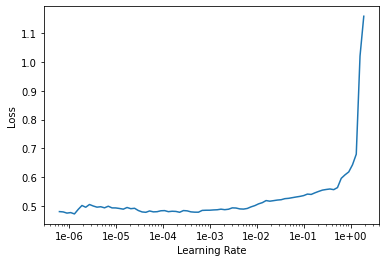

In [0]:
learn_cls.freeze_to(-2)
learn_cls.lr_find()
learn_cls.recorder.plot(skip_end= 1)

In [0]:
learn_cls.fit_one_cycle(4,slice(1e-04/(2.6**4),1e-04),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.468120,0.477004,0.772668,00:07
1,0.477978,0.471769,0.777924,00:06
2,0.463849,0.465606,0.779238,00:06
3,0.466369,0.470182,0.776610,00:06


In [0]:
learn_cls.save('cls-1')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


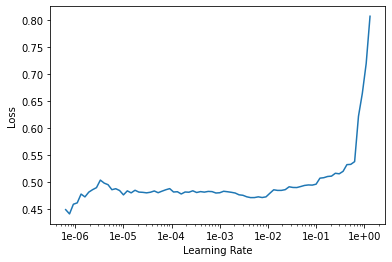

In [0]:
learn_cls.freeze_to(-3)
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.load('cls-1')
learn_cls.fit_one_cycle(4,slice(2e-03/(2.6**4),2e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.478874,0.475195,0.780552,00:06
1,0.463834,0.460439,0.795007,00:06
2,0.407472,0.472388,0.793693,00:06
3,0.354496,0.474396,0.801577,00:07


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


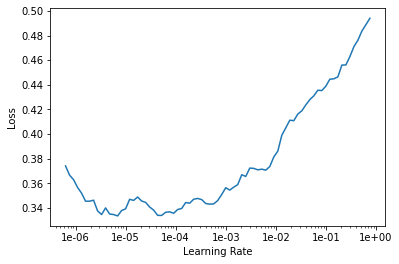

In [0]:
learn_cls.unfreeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.save('cls-2')

In [0]:
learn_cls.fit_one_cycle(8,slice(1e-04/(2.6**4),1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.340243,0.492097,0.796321,00:07
1,0.338464,0.476713,0.797635,00:07
2,0.340952,0.475971,0.791064,00:07
3,0.329256,0.482461,0.804205,00:06
4,0.338049,0.495166,0.800263,00:07
5,0.329684,0.492153,0.800263,00:06
6,0.330900,0.491640,0.797635,00:06
7,0.331564,0.484041,0.798949,00:06


In [0]:
def preds(ds_type):
  preds = learn_cls.get_preds(ds_type)[0].detach().cpu().numpy()
  sampler = [i for i in learn_cls.data.dl(ds_type).sampler]
  reverse_sampler = np.argsort(sampler)
  return preds[reverse_sampler, :]

y_pred = preds(DatasetType.Test)


In [0]:
sample_submission = pd.read_csv(path/'sample_submission.csv')
sample_submission['target'] = np.argmax(y_pred, axis=1)
sample_submission.to_csv("predictions.csv", index=False, header=True)